# Downward inference
In this jupyter notebook we will show simple example downward inference in [Logical Neural Networks](https://github.com/IBM/LNN) (LNN).


## Model definition

For purpose of showing downward inference we extend the example from first notebook.

First part will be same:

In [2]:
from lnn import Model, Predicate, Variable, Implies, Exists, World, Fact, ForAll, Or

# create empty model
model = Model()

# define predicates
grecian = Predicate(name="grecian")
mortal = Predicate(name="mortal")
native_of_greece = Predicate(name="native_of_greece")
resident_of_greece = Predicate(name="resident_of_greece")

# add predicates to the model
model.add_formulae(grecian, mortal, native_of_greece, resident_of_greece)

# define free variable
x = Variable("x")

# define our axiom
all_grecians_are_native_or_resident = ForAll(
    x,
    Implies(
        grecian(x),
        Or(native_of_greece(x), resident_of_greece(x)),
        name="grecians_are_native_or_resident",
    ),
    name="all_grecians_are_native_or_resident",
    world=World.AXIOM,
)

grecians_are_mortals = Implies(grecian(x), mortal(x), name="grecians_are_mortals")

# add axiom to the model
model.add_formulae(grecians_are_mortals, all_grecians_are_native_or_resident)

# add facts to our model
from lnn import Fact

# add facts to our model
model.add_facts(
    {
        "grecian": {
            "Zeus": Fact.TRUE,
            "Socrates": Fact.TRUE,
            "Confucius": Fact.FALSE,
            "Great Pyramid of Giza": Fact.FALSE,
        },
        "mortal": {
            "Zeus": Fact.FALSE,
            "Socrates": Fact.TRUE,
            "Confucius": Fact.TRUE,
            "Great Pyramid of Giza": Fact.FALSE,
        },
        "native_of_greece": {
            "Zeus": Fact.FALSE,
            "Socrates": Fact.TRUE,
            "Confucius": Fact.FALSE,
            "Great Pyramid of Giza": Fact.FALSE,
        },
        "resident_of_greece": {
            "Zeus": Fact.TRUE,
            "Socrates": Fact.FALSE,
            "Confucius": Fact.FALSE,
            "Great Pyramid of Giza": Fact.FALSE,
        },
    }
)


We will extend our example by one new axiom and predicate.

> All *humans* are *mortal*.

We can express it as [First-order logic](https://en.wikipedia.org/wiki/First-order_logic) in similar fashion as before.

> $(\forall x)(human(x) \implies mortal(x))$

Now express this knowledge in LNN model.

In [3]:
# from lnn import ForAll

# # define mortal predicate
# mortal = Predicate(name="mortal")

# # define new axiom that all humans are mortal
# all_humans_are_mortal = ForAll(
#     x,
#     Implies(human(x), mortal(x), name="human_is_mortal"),
#     name="all_humans_are_mortal",
#     world=World.AXIOM
# )

# # add new predicate and axiom to the model
# model.add_formulae(mortal, all_humans_are_mortal)

Verify the graph structure.

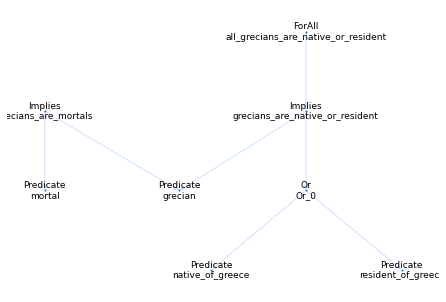

In [4]:
from lnn.utils import plot_graph

plot_graph(model)

And print the model.

In [5]:
model.print()


***************************************************************************
                                LNN Model

AXIOM  ForAll: all_grecians_are_native_or_resident (x)          TRUE (1.0, 1.0)

OPEN   Implies: grecians_are_native_or_resident(x) 

OPEN   Or: Or_0(x) 

OPEN   Implies: grecians_are_mortals(x) 

OPEN   Predicate: resident_of_greece(x0) 

OPEN   Predicate: native_of_greece(x0) 

OPEN   Predicate: mortal(x0) 
'Great Pyramid of Giza'                                    FALSE (0.0, 0.0)
'Confucius'                                                 TRUE (1.0, 1.0)
'Socrates'                                                  TRUE (1.0, 1.0)
'Zeus'                                                     FALSE (0.0, 0.0)

OPEN   Predicate: grecian(x0) 
'Great Pyramid of Giza'                                    FALSE (0.0, 0.0)
'Confucius'                                                FALSE (0.0, 0.0)
'Socrates'                                                  TRUE (1.0, 1.0)
'Zeus

## Inference

Now, we can examine *downward inference* in detail.

So called downward inference starts in the root node (formula) of syntax tree and yields outputs for each sub-formula, given the truth of the formula. During this process truth bounds are tightened for each sub-formulae and ultimately for our facts.

In [6]:
from lnn import Direction

# perform inference
steps, facts_inferred = model.infer(direction=Direction.DOWNWARD)

# result of the inference can be checked, inference happened in single step and zero facts were inferred
steps, facts_inferred

(1, tensor(0.))

Examine the printed model and corresponding truth values. We infered zero new facts (truth values are `UNKNOWN`) because we did not calculate truth values of axioms from given facts (upward inference) first.

In [7]:
model.print()


***************************************************************************
                                LNN Model

AXIOM  ForAll: all_grecians_are_native_or_resident (x)          TRUE (1.0, 1.0)

OPEN   Implies: grecians_are_native_or_resident(x) 
'Confucius'                                              UNKNOWN (0.0, 1.0)
'Zeus'                                                   UNKNOWN (0.0, 1.0)
'Socrates'                                               UNKNOWN (0.0, 1.0)
'Great Pyramid of Giza'                                  UNKNOWN (0.0, 1.0)

OPEN   Or: Or_0(x) 
'Confucius'                                              UNKNOWN (0.0, 1.0)
'Zeus'                                                   UNKNOWN (0.0, 1.0)
'Socrates'                                               UNKNOWN (0.0, 1.0)
'Great Pyramid of Giza'                                  UNKNOWN (0.0, 1.0)

OPEN   Implies: grecians_are_mortals(x) 
'Confucius'                                              UNKNOWN (0.0, 1.0)


So let us do upward inference first.

In [8]:
# perform inference
steps, facts_inferred = model.infer(direction=Direction.UPWARD)

# result of the inference can be checked, inference happened in single step and six facts were inferred
steps, facts_inferred

(1, tensor(6., grad_fn=<AddBackward0>))

Now we will repeat downward inference once more and check the results again.

In [9]:
# perform inference
steps, facts_inferred = model.infer(direction=Direction.DOWNWARD)

# result of the inference can be checked, inference happened in single step and four facts were inferred
steps, facts_inferred

(1, tensor(4., grad_fn=<AddBackward0>))

We can see that during downward inference truth values for $human\_is\_mortal(x)$ and $mortal(x0)$ were infered.

The truth values for $mortal(x)$ were infered from truth values of predicate $human(x)$ and axiom $human\_is\_mortal(x)$ (we know that this implication holds for each human).

Note that it does not matter that `Zeus` and `Great Pyramid of Giza` are not humans. The truth table of an implication still holds (see truth table below).

| $P$     | $Q$     | $P \implies Q$ |
|---------|---------|:--------------:|
| *False* | *False* |     *True*     |
| *False* | *True*  |     *True*     |
| *True*  | *False* |     *False*    |
| *True*  | *True*  |     *True*     |

This inference is possible with set of *inference rules*. Details can be examined in the original [paper](https://arxiv.org/abs/2006.13155).

In [10]:
model.print()


***************************************************************************
                                LNN Model

AXIOM  ForAll: all_grecians_are_native_or_resident (x)          TRUE (1.0, 1.0)

OPEN   Implies: grecians_are_native_or_resident(x) 
'Confucius'                                                 TRUE (1.0, 1.0)
'Zeus'                                                      TRUE (1.0, 1.0)
'Socrates'                                                  TRUE (1.0, 1.0)
'Great Pyramid of Giza'                                     TRUE (1.0, 1.0)

OPEN   Or: Or_0(x) 
'Confucius'                                              UNKNOWN (0.0, 1.0)
'Zeus'                                                      TRUE (1.0, 1.0)
'Socrates'                                                  TRUE (1.0, 1.0)
'Great Pyramid of Giza'                                  UNKNOWN (0.0, 1.0)

OPEN   Implies: grecians_are_mortals(x) 
'Confucius'                                                 TRUE (1.0, 1.0)
